## Plotting Results

In [1]:
import importlib
import os
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt

import neuralplayground.agents.whittington_2020_extras.whittington_2020_analyse as analyse
from neuralplayground.plotting import PlotSim

In [3]:
simulation_id = "TEM_custom_plot_sim"
from neuralplayground.saved_models import fetch_model_path
save_path = fetch_model_path("tem_in_2D")
training_dict = pd.read_pickle(os.path.join(os.getcwd(), save_path, "params.dict"))
model_weights = pd.read_pickle(os.path.join(save_path, "agent"))
model_spec = importlib.util.spec_from_file_location("model", save_path + "whittington_2020_model.py")
model = importlib.util.module_from_spec(model_spec)
model_spec.loader.exec_module(model)
params = pd.read_pickle(os.path.join(save_path, "agent_hyper"))
tem = model.Model(params)
tem.load_state_dict(model_weights)
tem.eval()

Model(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (w_p): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (g_init): ParameterList(
      (0): Parameter containing: [torch.float32 of size 30]
      (1): Parameter containing: [torch.float32 of size 30]
      (2): Parameter containing: [torch.float32 of size 24]
      (3): Parameter containing: [torch.float32 of size 18]
      (4): Parameter containing: [torch.float32 of size 18]
  )
  (logsig_g_init): Param

In [4]:
plotting_loop_params = {"n_episode": 5000}
sim = PlotSim(
    simulation_id=simulation_id,
    agent_class=training_dict["agent_class"],
    agent_params=training_dict["agent_params"],
    env_class=training_dict["env_class"],
    env_params=training_dict["env_params"],
    plotting_loop_params=plotting_loop_params,
)
print(sim)

In [5]:
trained_agent, trained_env = sim.plot_sim(save_path, n_walks=1000, random_state=False, custom_state=[0.5,0.5])
trained_env.plot_trajectory()
# Load environments and model_input using pickle
with open(os.path.join(save_path, "NPG_environments.pkl"), "rb") as f:
    environments = pickle.load(f)
with open(os.path.join(save_path, "NPG_model_input.pkl"), "rb") as f:
    model_input = pickle.load(f)

---> Initializing models


KeyError: 'arg_env_params'

In [ ]:
training_dict["params"] = training_dict["agent_params"]
del training_dict["agent_params"]
agent = training_dict["agent_class"](**training_dict["params"])

In [ ]:
with torch.no_grad():
    forward = tem(model_input, prev_iter=None)

In [6]:
include_stay_still = False
shiny_envs = [False, False, False, False]
env_to_plot = 0
envs_to_avg = shiny_envs if shiny_envs[env_to_plot] else [not shiny_env
                                                           for shiny_env in shiny_envs]

In [7]:
correct_model, correct_node, correct_edge = analyse.compare_to_agents(
    forward, tem, environments, include_stay_still=include_stay_still)
zero_shot = analyse.zero_shot(forward, tem, environments, 
                              include_stay_still=include_stay_still)
occupation = analyse.location_occupation(forward, tem, environments)
g, p = analyse.rate_map(forward, tem, environments)
from_acc, to_acc = analyse.location_accuracy(forward, tem, environments)

NameError: name 'forward' is not defined

#### Grid cell rate maps

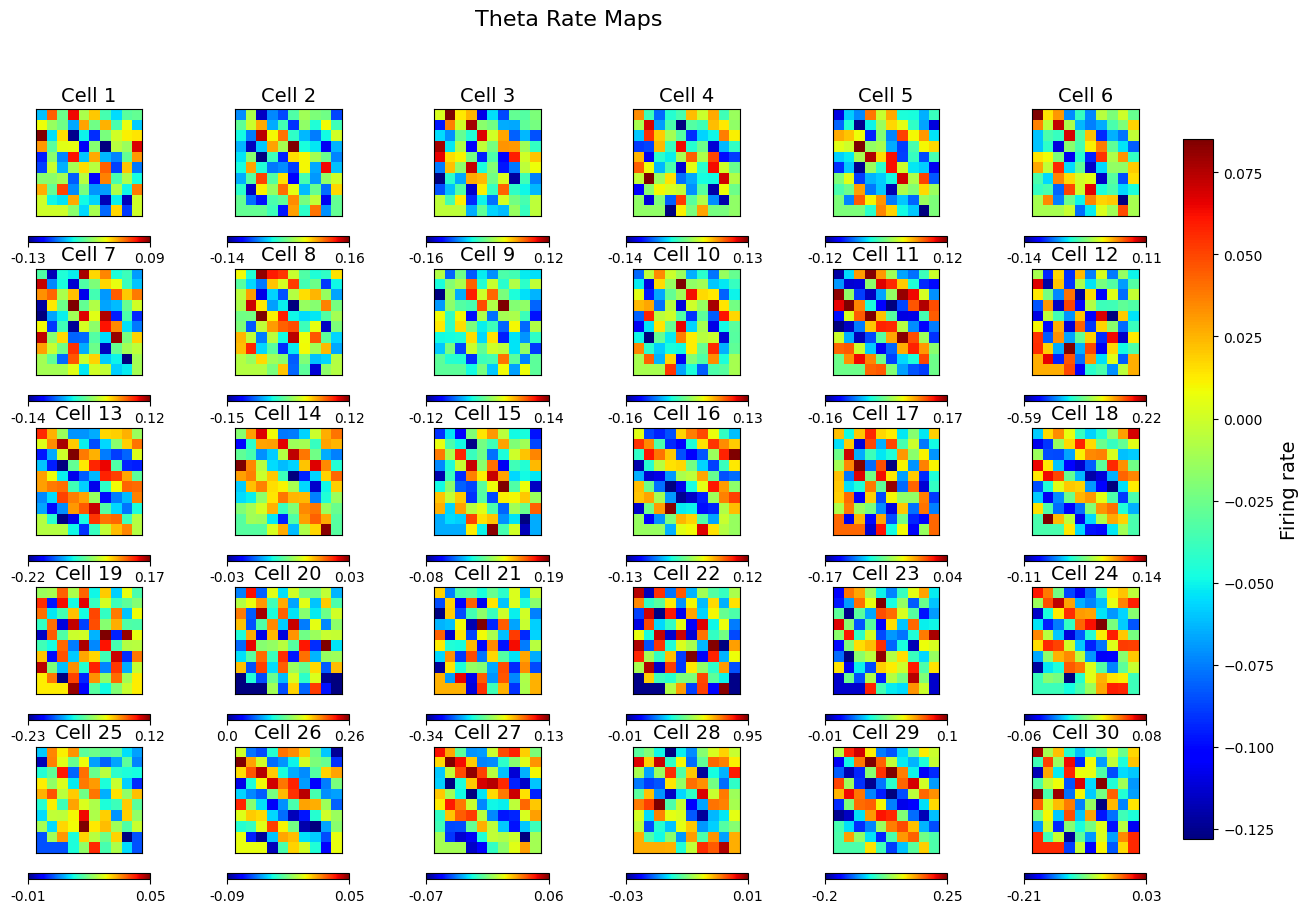

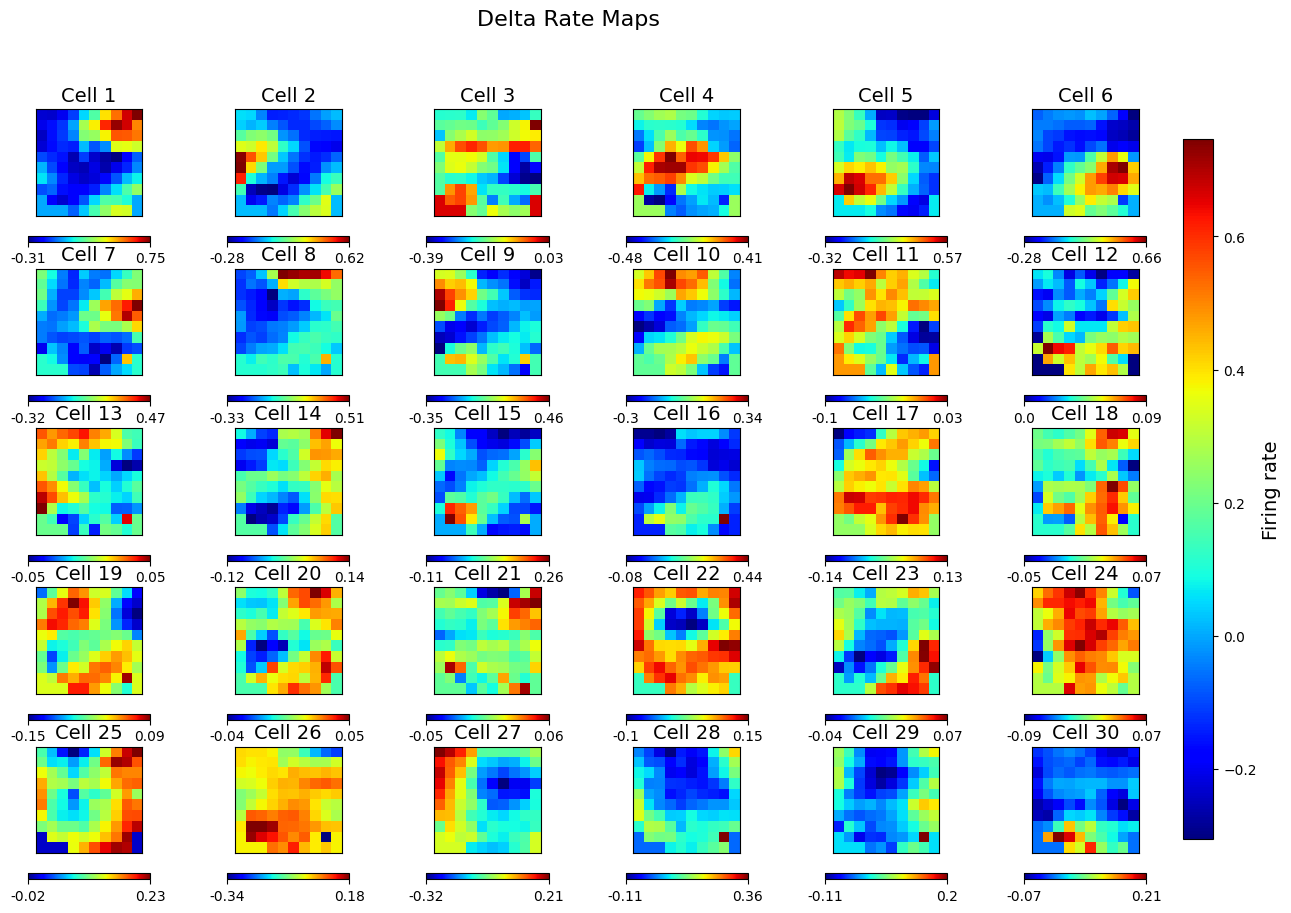

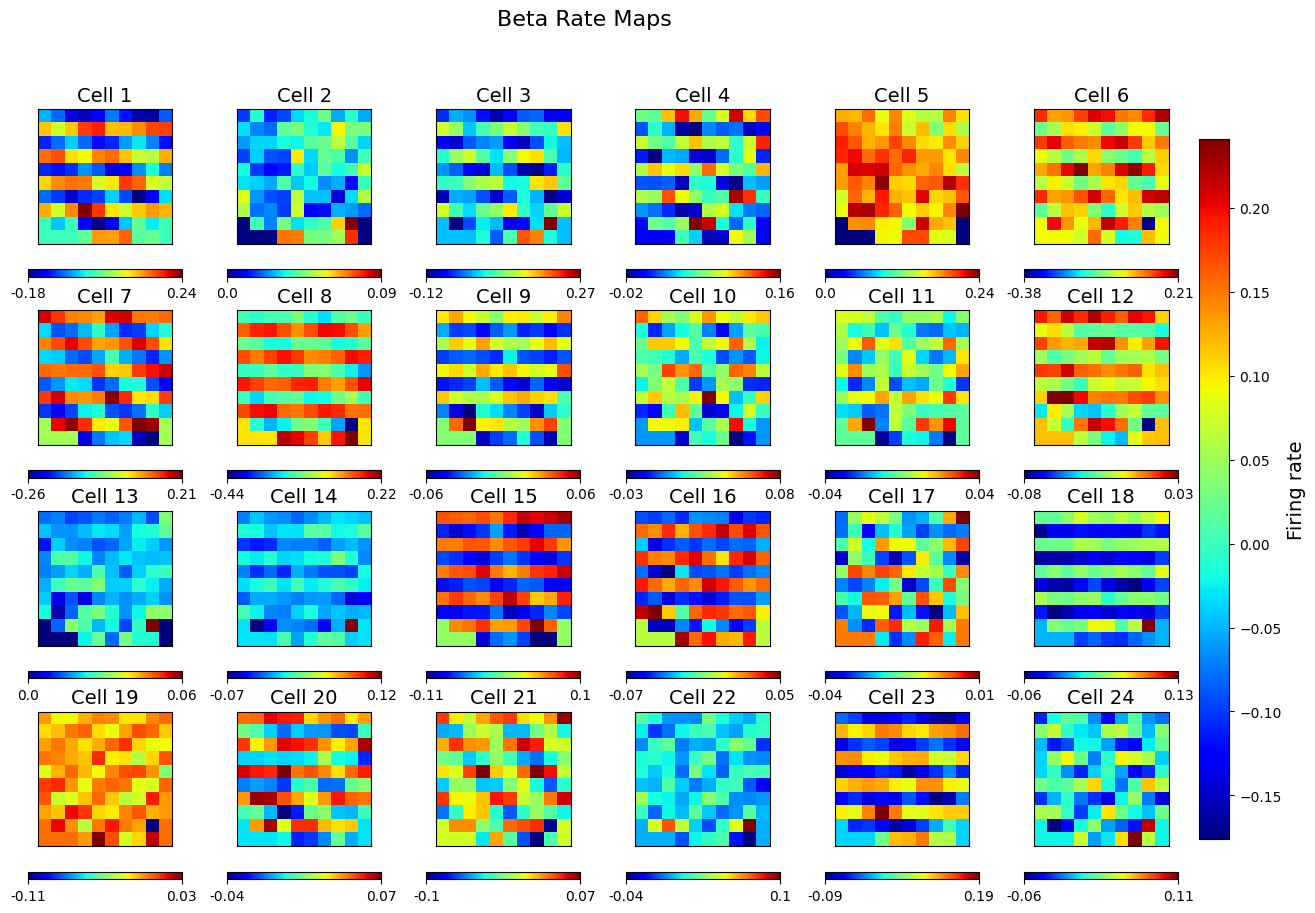

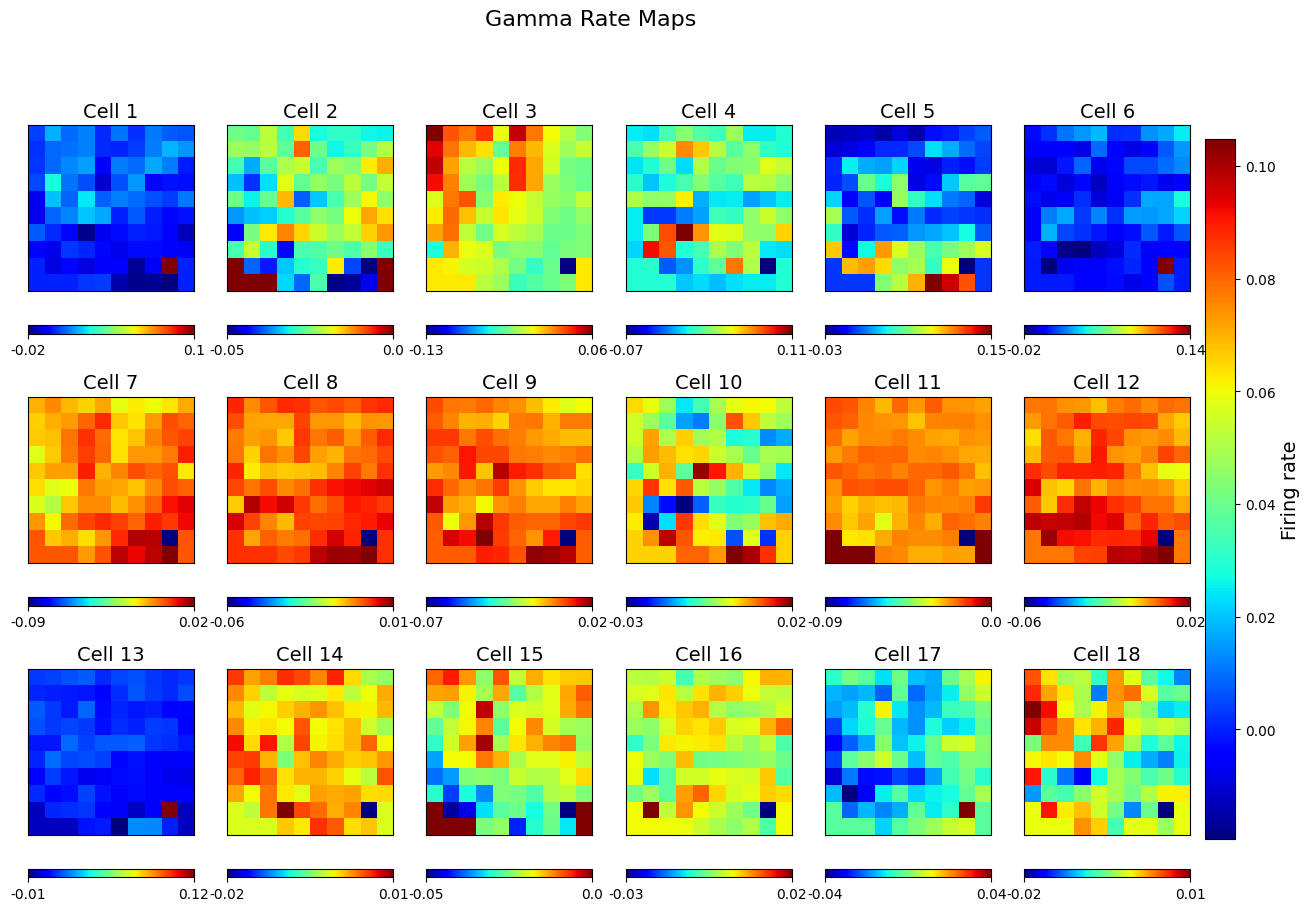

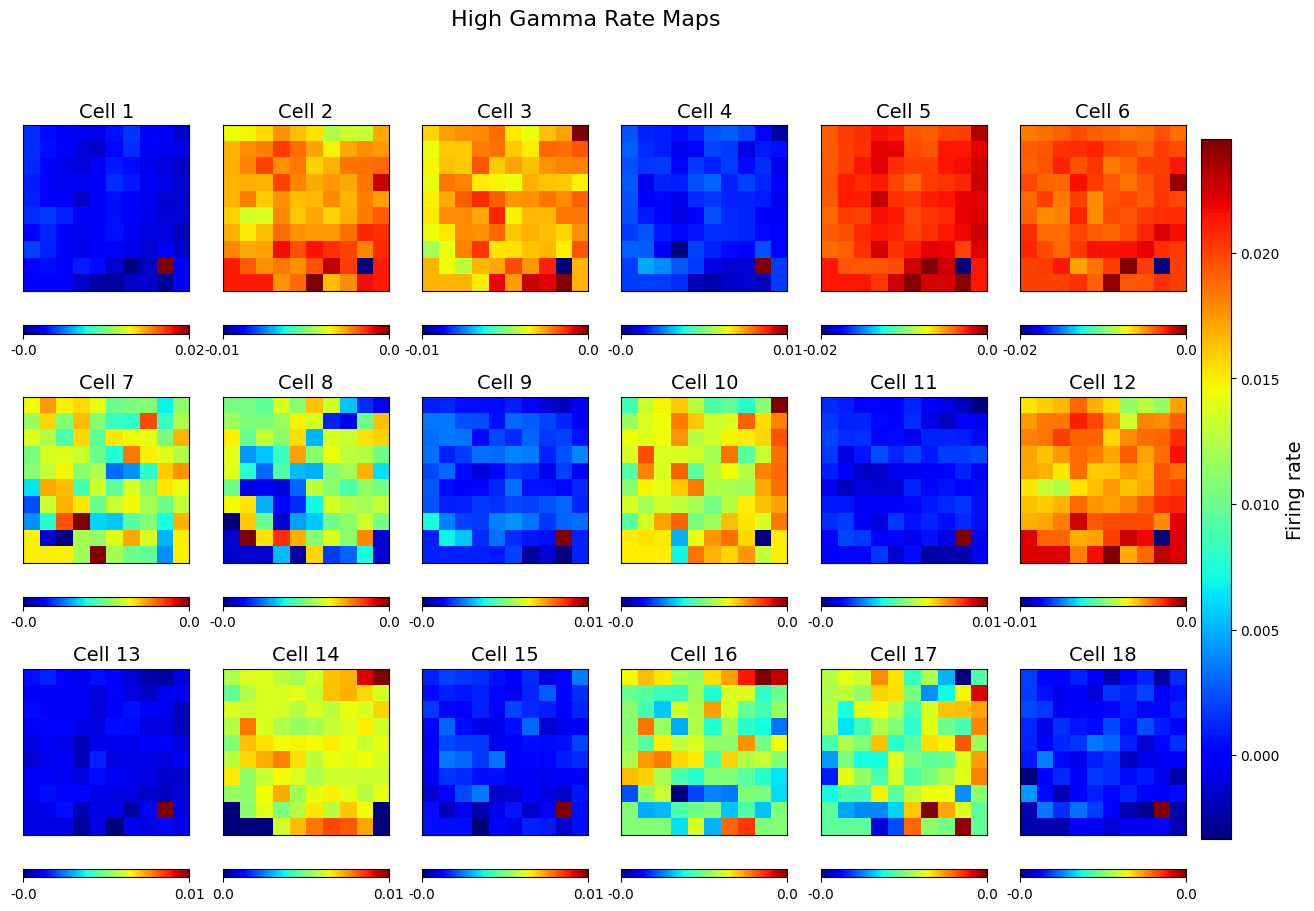

In [19]:
agent.plot_rate_map(g);

#### Place cell rate maps

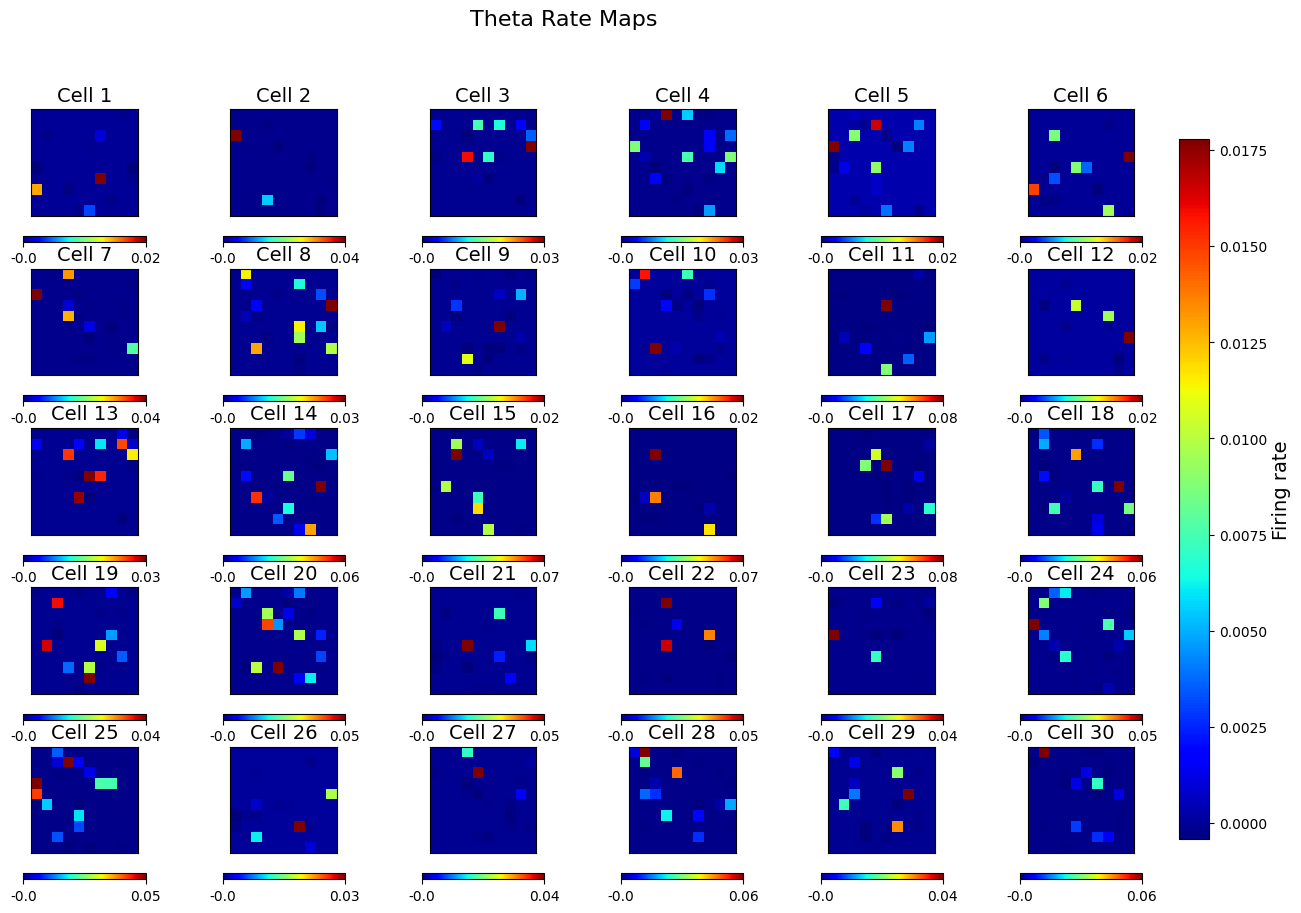

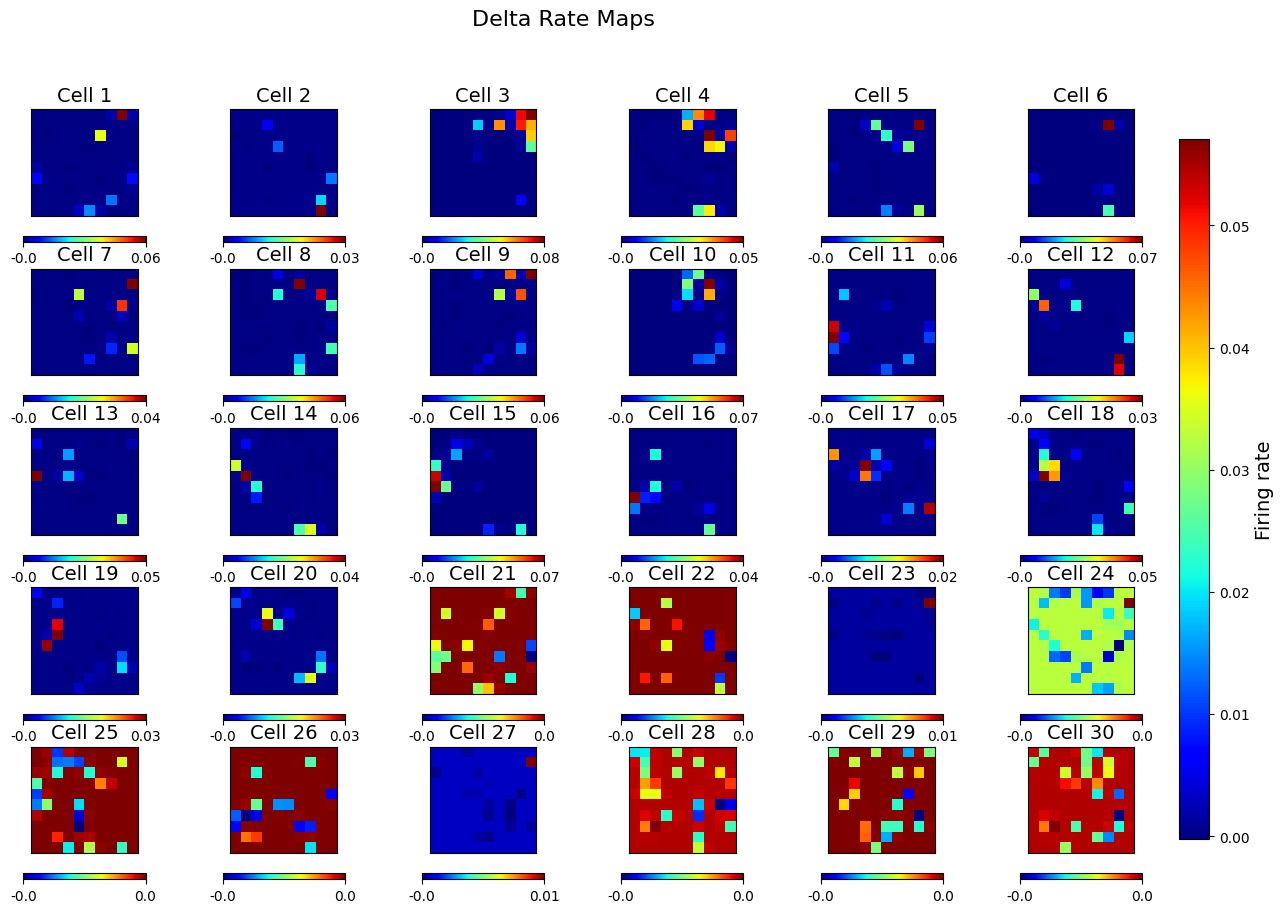

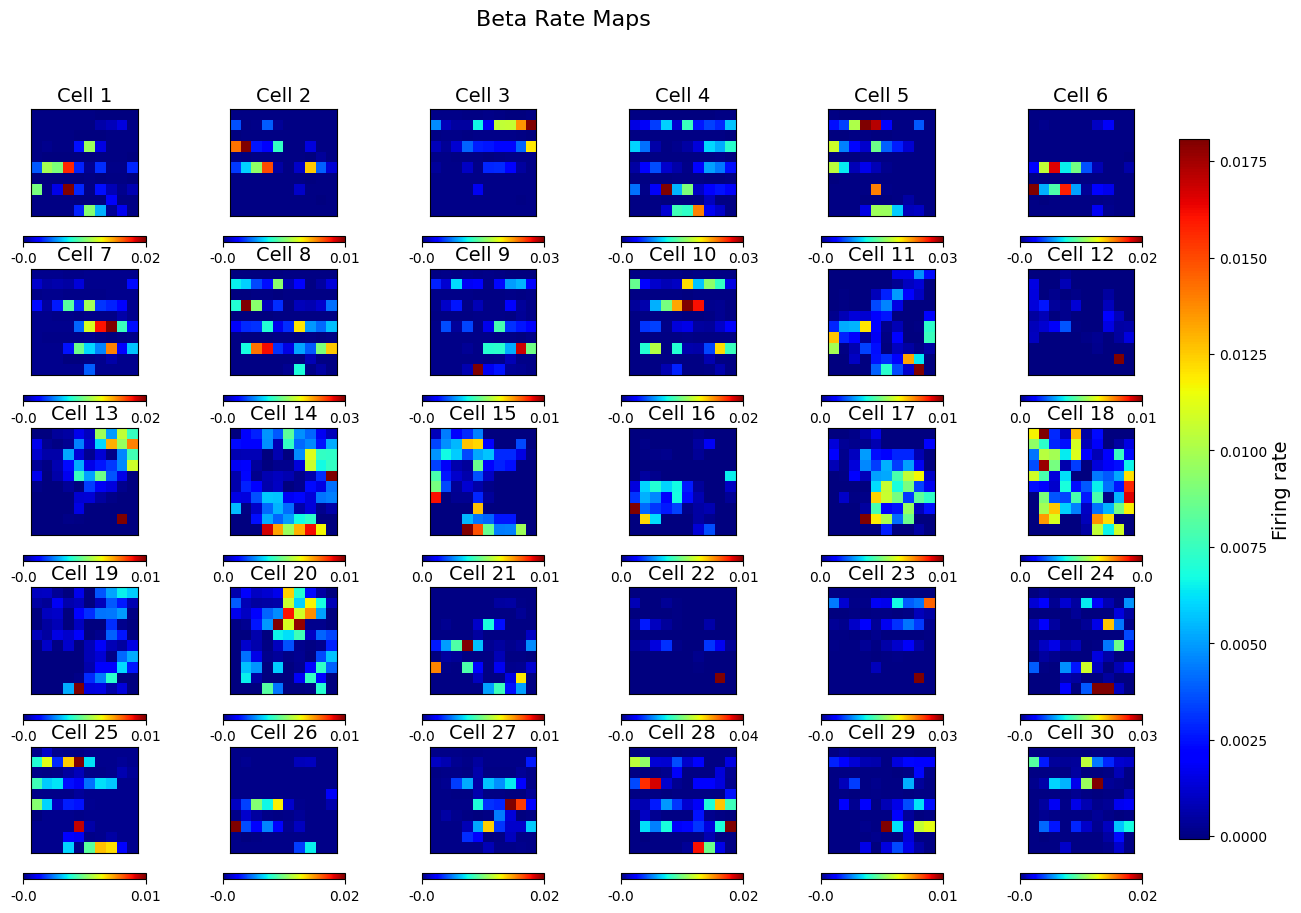

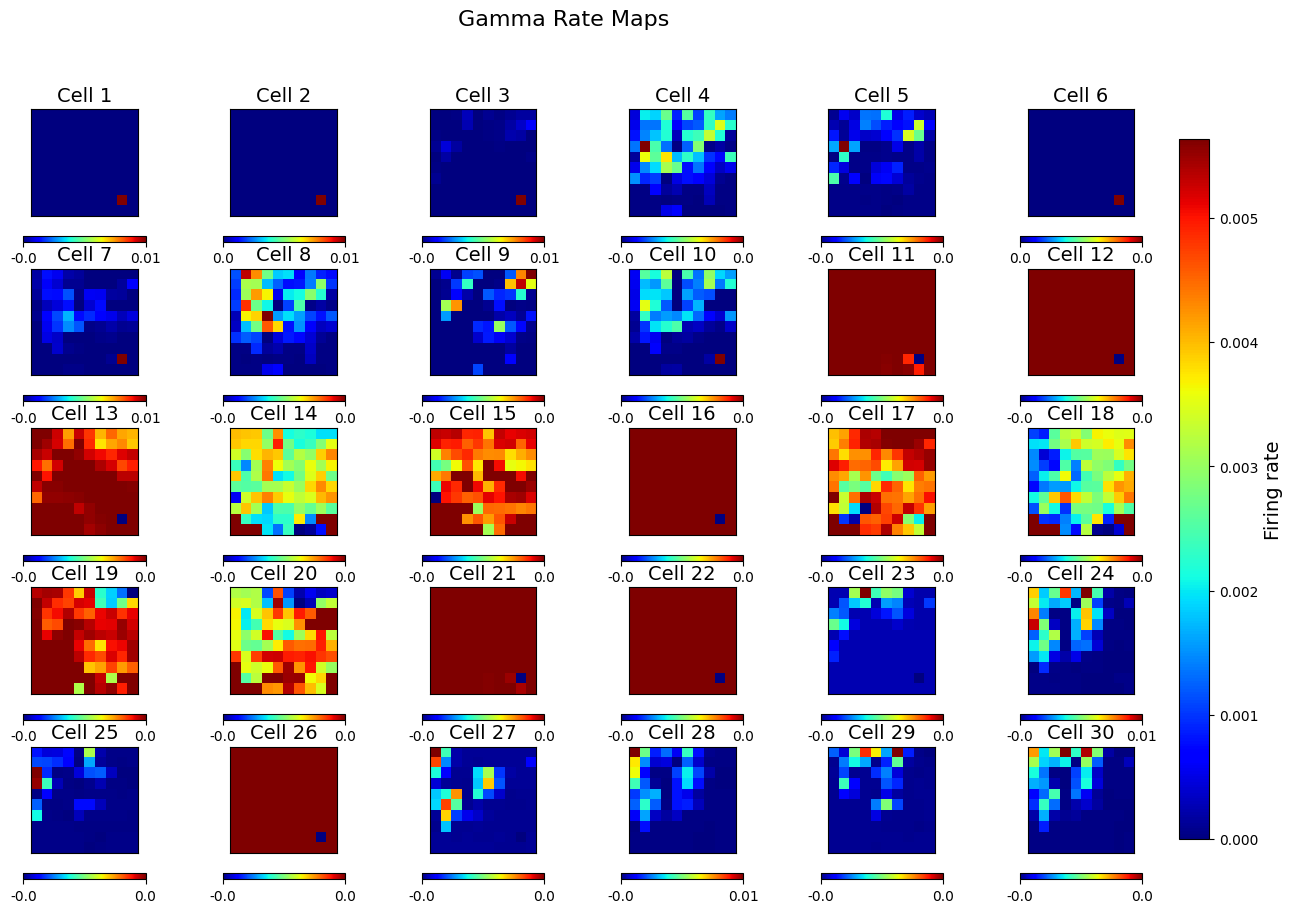

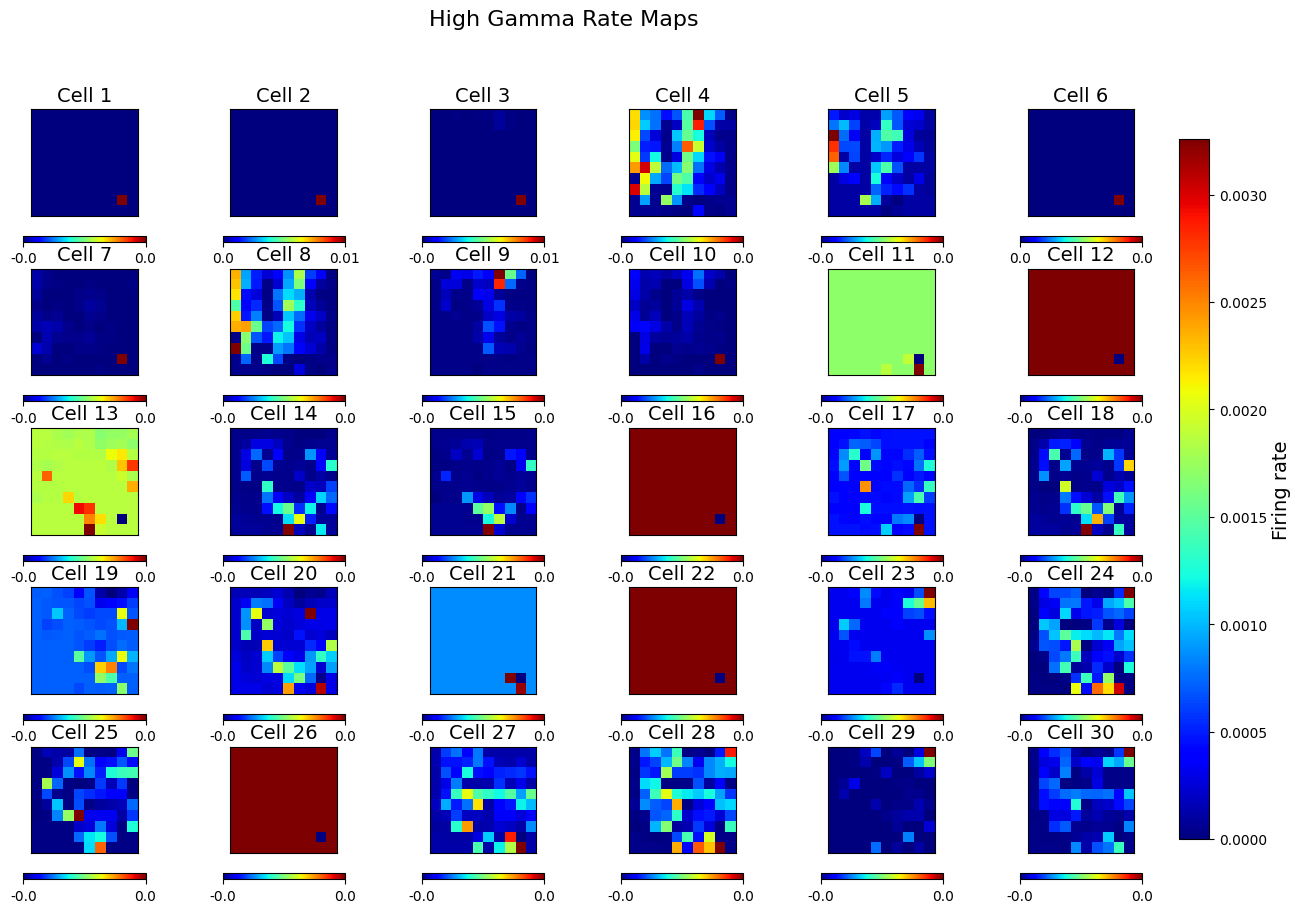

In [20]:
agent.plot_rate_map(p);